# Bamboo Report 0.1a

### Contents:
- Reference engine simulation
- Variable water content simulation
- Variable channel height simulation

In [2]:
#Import required modules
import bamboo as bam
import bamboo.cooling as cool
import bamboo.materials

import numpy as np
import matplotlib.pyplot as plt
import pypropep as ppp
import bamboo.plot
import thermo

# Reference engine
### *Reference engine setup*

In [3]:
'''Chamber conditions'''
pc = 15e5                   #Chamber pressure (Pa)
mdot = 5.4489               #Mass flow rate (kg/s)
p_amb = 1.01325e5           #Ambient pressure (Pa). 1.01325e5 is sea level atmospheric.
OF_ratio = 3.5              #Oxidiser/fuel mass ratio
water_mass_fraction = 0.10  #Fraction of the fuel that is water, by mass

'''Get combustion properties from pypropep'''
ppp.init()
e = ppp.Equilibrium()
ipa = ppp.PROPELLANTS['ISOPROPYL ALCOHOL']
water = ppp.PROPELLANTS['WATER']
n2o = ppp.PROPELLANTS['NITROUS OXIDE']

#Add propellants by mass fractions (note the mass fractions can add up to more than 1)
e.add_propellants_by_mass([(ipa, 1-water_mass_fraction), (water, water_mass_fraction), (n2o, OF_ratio)])

#Adiabatic combustion using chamber pressure                      
e.set_state(P = pc/1e5, type='HP')                      

gamma = e.properties.Isex   #pyrpopep uses 'Isex' for the ratio of specific heats
cp = 1000*e.properties.Cp   #Cp is given in kJ/kg/K, we want J/kg/K
Tc = e.properties.T

'''Set up the engine object'''
perfect_gas = bam.PerfectGas(gamma = gamma, cp = cp)    #Gas for frozen flow
chamber_conditions = bam.ChamberConditions(pc, Tc, mdot)
nozzle = bam.Nozzle.from_engine_components(perfect_gas, chamber_conditions, p_amb, type = "cone")
engine = bam.Engine(perfect_gas, chamber_conditions, nozzle)

'''Check the thrust and specific impulse'''
print("")
print(f"Chamber Temperature: {Tc} K")
print(f"Gamma = {gamma}")
print(f"cp = {cp} J/kg/K")
print("")
print(f"Sea level thrust = {engine.thrust(1e5)/1000} kN")
print(f"Sea level Isp = {engine.isp(1e5)} s")



Loaded 1921 thermo species
Loaded 1031 propellants

Chamber Temperature: 2813.9267227024607 K
Gamma = 1.1990318980924197
cp = 2408.5593495976937 J/kg/K

Sea level thrust = 12.07115110440335 kN
Sea level Isp = 225.90153040919307 s


### *Reference cooling simulation*

In [4]:
'''Chamber and wall geometry'''
Ac = np.pi*0.1**2                      #Chamber cross-sectional area (m^2)
wall_thickness = 1e-3                  #Thickness of the metal engine liner (m)
L_star = 1.2                           #L_star = Volume_c/Area_t
chamber_length = L_star*nozzle.At/Ac   #Length of the combustion chamber
engine.add_geometry(chamber_length, Ac, wall_thickness)

'''Coolant jacket'''
mdot_coolant = mdot/(OF_ratio + 1)              #Coolant mass flow rate
inlet_T = 298.15                                #Coolant inlet temperature
inlet_p0 = 20e5                                 #Tank / inlet coolant stagnation pressure (Pa)
wall_material = bam.materials.StainlessSteel304 #Stainless steel wall
channel_width = 3e-2                            #Rectangular oolant channel width (m)
channel_height = 2e-2                           #Rectangular channel height (m)

#Choose the models we want to use for transport properties of the coolant and exhaust gas
thermo_coolant = thermo.mixture.Mixture(['isopropanol', 'water'], ws = [1 - water_mass_fraction, water_mass_fraction])
#thermo_gas = thermo.mixture.Mixture(['N2', 'H2O', 'CO2'], zs = [e.composition['N2'], e.composition['H2O'], e.composition['CO2']])   
#gas_transport = cool.TransportProperties(model = "thermo", thermo_object = thermo_gas, force_phase = 'g')
gas_transport = cool.TransportProperties(model = "custom", custom_mu = 7.5e-5, custom_k =  0.20, custom_Pr = 0.62)
coolant_transport = cool.TransportProperties(model = "thermo", thermo_object = thermo_coolant)

#Add the cooling jacket
engine.add_cooling_jacket(wall_material, 
                               inlet_T, 
                               inlet_p0, 
                               coolant_transport, 
                               mdot_coolant, 
                               configuration = "spiral", 
                               channel_shape = "rectangle", 
                               channel_width = channel_width,
                               channel_height = channel_height)

#Add the exhaust gas transport properties
engine.add_exhaust_transport(gas_transport)

'''Graphite insert'''
ablative_material = bam.materials.Graphite
engine.add_ablative(ablative_material)

#Print the wall and ablative material properties
print("Wall material properties:")
print(wall_material)

print("\n Graphite insert properties:")
print(ablative_material)
print("")

#Run simulation
data = engine.steady_heating_analysis(to_json = False, h_gas_model = '3', h_coolant_model = '2')


Wall material properties:
bamboo.cooling.Material Object 
Young's modulus = 193.0 GPa 
0.2% Yield Stress = 205.0 MPa 
Poisson's ratio = nan
alpha = nan strain/K
Thermal conductivity = 16.2 W/m/K
(may also have a specific heat capacity (self.c) and density (self.rho))

 Graphite insert properties:
bamboo.cooling.Material Object 
Young's modulus = nan GPa 
0.2% Yield Stress = nan MPa 
Poisson's ratio = nan
alpha = nan strain/K
Thermal conductivity = 63.81001 W/m/K
(may also have a specific heat capacity (self.c) and density (self.rho))

Coolant temperature at the wall was above its boiling point when using the Sieder-Tate equation (h_coolant_model = '2') - results should be used with caution.


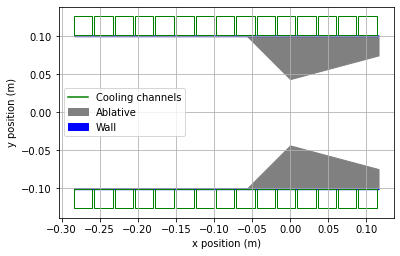

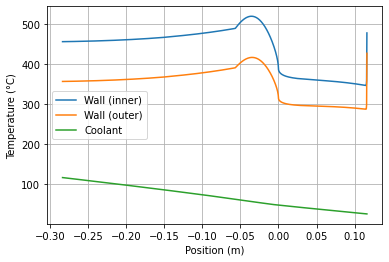

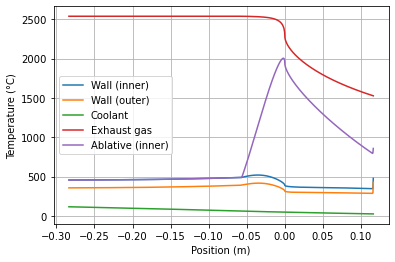

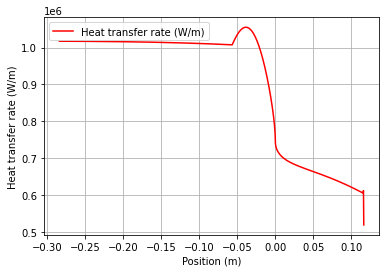

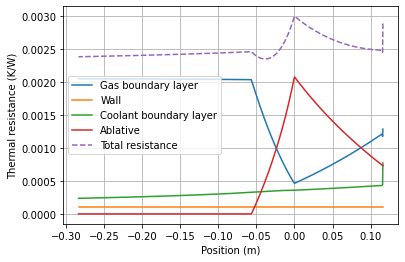

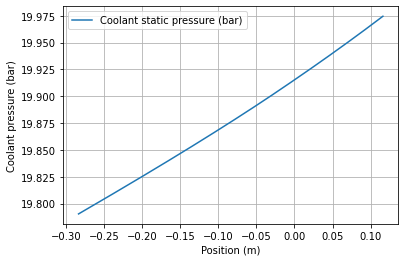

In [5]:
#Show plots
engine.plot_geometry()
bam.plot.plot_temperatures(data, show_gas=False, show_ablative = False)
bam.plot.plot_temperatures(data, show_gas=True)
bam.plot.plot_qdot(data)
bam.plot.plot_resistances(data)
bam.plot.plot_jacket_pressure(data)
plt.show()

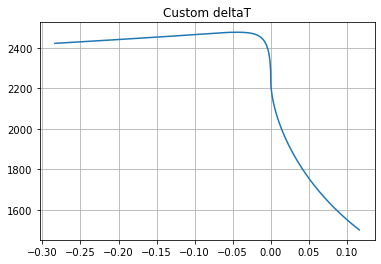

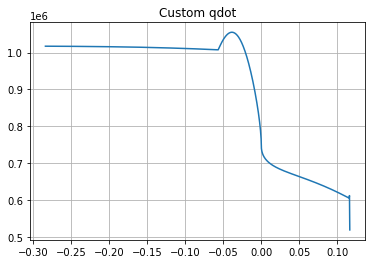

In [6]:
deltaT = np.zeros(len(data['x']))
qdot = np.zeros(len(data['x']))

for i in range(len(data['x'])):
    deltaT[i] = data['T_gas'][i] - data['T_coolant'][i]
    qdot[i] = deltaT[i]/(data['R_gas'][i] + data['R_ablative'][i] + data['R_wall'][i] + data['R_coolant'][i])


plt.title("Custom deltaT")
plt.plot(data['x'], deltaT)
plt.grid()
plt.show()

plt.title("Custom qdot")
plt.grid()
plt.plot(data['x'], qdot)
plt.show()